In [43]:
import pandas as pd


data = pd.read_csv(r'..\data\processed\cleaned-data.csv')
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,1,0,No
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,1,0,No
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,1,0,No
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,1,0,No
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,1,0,No


- We cannot use `ScheduledDay` & `AppointmentDay` columns together because this is in raw formate, that's we can extract other meaningfull insights from it like `waiting time` which is difference between appointment day and schedule day.

In [44]:
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

data['WaitingTime'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days

- Also we can create another column `Appoint Day of Week` which will show how many people are no-show on a particular day, because generally most of the people are absent on weekends.

In [45]:
data['AppointmentDayOfWeek'] = data['AppointmentDay'].dt.dayofweek  # 0 means monday, 6 sunday

- And, with the help of these columns, we will extract another feature `Wait Groups` which is categorical column and help model for best split because this is a classification problem.

In [46]:
data['WaitGroup'] = pd.cut(data['WaitingTime'],
                         bins=[-1, 0, 3, 7, 30, 120],
                         labels=['SameDay', 'Short', 'Mid', 'Long', 'VeryLong'])

- We can also create chronic status by checking the patient's `hipertension`, `diabetes` and `alcoholism`. If the patient has all these three points, then the chances of that show of pateints increases.

In [47]:
data['ChronicCount'] = data['Hipertension'] + data['Diabetes'] + data['Alcoholism']

In [48]:
data['ChronicGroup'] = pd.cut(data['ChronicCount'],
                            bins=[-1, 0, 1, 3],
                            labels=['None', 'Single', 'Multiple'])

- And lastly we will Label Encode all these columns, because machine learning models only understand numerical data. 

In [49]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Gender', 'Neighbourhood', 'AppointmentDayOfWeek', 'WaitGroup', 'ChronicGroup', 'No-show']
encoders = {}  # encoders['Gender'].transform(['Male'])  # Output:1 

for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

#### We save all the encoders for encoding input feature while predicting.

In [50]:
encoders

{'Gender': LabelEncoder(),
 'Neighbourhood': LabelEncoder(),
 'AppointmentDayOfWeek': LabelEncoder(),
 'WaitGroup': LabelEncoder(),
 'ChronicGroup': LabelEncoder(),
 'No-show': LabelEncoder()}

In [51]:
data.drop(columns=['ScheduledDay', 'AppointmentDay', 'ChronicCount'], inplace=True)

In [52]:
data.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime,AppointmentDayOfWeek,WaitGroup,ChronicGroup
0,0,62,39,0,1,0,0,1,0,0,-1,4,5,2
1,1,56,39,0,0,0,0,1,0,0,-1,4,5,1
2,0,62,45,0,0,0,0,1,0,0,-1,4,5,1
3,0,8,54,0,0,0,0,1,0,0,-1,4,5,1
4,0,56,39,0,1,1,0,1,0,0,-1,4,5,0


- So out final input parameters are -> `Gender, Age, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received, WaitingTime, AppointmentDayOfWeek, WaitGroup and ChronicGroup`.

- Lastly for more accurate and unbaised result we want to organize all the categories of output feature `(No-show)`.

([<matplotlib.patches.Wedge at 0x1e8fd65c190>,
 [Text(-0.8845609129319836, 0.6538745990730456, '0'),
  Text(0.8845609700955153, -0.653874521742269, '1')],
 [Text(-0.4824877706901728, 0.35665887222166115, '79.74%'),
  Text(0.482487801870281, -0.3566588300412376, '20.26%')])

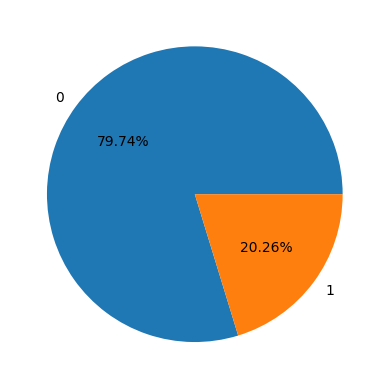

In [53]:
import matplotlib.pyplot as plt

plt.pie(
    data['No-show'].value_counts(),
    labels=data['No-show'].value_counts().index,
    autopct="%1.2f%%"
)

In [54]:
x = data.drop('No-show', axis=1)
y = data['No-show']

In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.777, random_state=42)

xresambled, yresembled = smote.fit_resample(x, y)

([<matplotlib.patches.Wedge at 0x1e8fd65fd90>,
 [Text(-0.21544619355772718, 1.0786950160640802, '0'),
  Text(0.21544615926977764, -1.0786950229123624, '1')],
 [Text(-0.11751610557694209, 0.5883790996713164, '56.27%'),
  Text(0.11751608687442415, -0.588379103406743, '43.73%')])

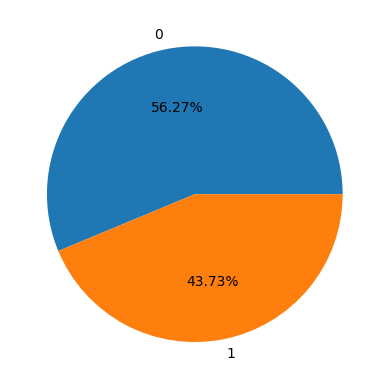

In [56]:
import matplotlib.pyplot as plt

plt.pie(
    yresembled.value_counts(),
    labels=yresembled.value_counts().index,
    autopct="%1.2f%%"
)

In [57]:
data.drop('No-show', axis=1, inplace=True)

In [58]:
data = xresambled.copy()
data['No-show'] = yresembled

In [59]:
data.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitingTime,AppointmentDayOfWeek,WaitGroup,ChronicGroup,No-show
0,0,62,39,0,1,0,0,1,0,-1,4,5,2,0
1,1,56,39,0,0,0,0,1,0,-1,4,5,1,0
2,0,62,45,0,0,0,0,1,0,-1,4,5,1,0
3,0,8,54,0,0,0,0,1,0,-1,4,5,1,0
4,0,56,39,0,1,1,0,1,0,-1,4,5,0,0


# Exporting Processed Data

In [60]:
data.to_csv('../data/processed/processed-data.csv', index=False, encoding='utf-8')